Import
===

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as sp
import scipy.linalg as spla
import math

Define Variables
===

In [2]:
N = 2          # number of basis functions
k = 16         # number of elements
c = 2          # speed
dt = 0.0002    # time step
T = 1          # end time
nt = int(T/dt) # number of time steps

Set Up Elements
===

In [3]:
elem_bounds = np.linspace(0,1,k+1)  # element boundaries
dx = elem_bounds[1]-elem_bounds[0]  # dx is same for all elements
nodes = np.stack((elem_bounds[0:k], elem_bounds[1:k+1])).transpose()  # node coordinates
#print(nodes)

Initial Condition
===

In [4]:
init_weights = np.sin(2*math.pi*nodes)
print(init_weights)

[[  0.00000000e+00   3.82683432e-01]
 [  3.82683432e-01   7.07106781e-01]
 [  7.07106781e-01   9.23879533e-01]
 [  9.23879533e-01   1.00000000e+00]
 [  1.00000000e+00   9.23879533e-01]
 [  9.23879533e-01   7.07106781e-01]
 [  7.07106781e-01   3.82683432e-01]
 [  3.82683432e-01   1.22464680e-16]
 [  1.22464680e-16  -3.82683432e-01]
 [ -3.82683432e-01  -7.07106781e-01]
 [ -7.07106781e-01  -9.23879533e-01]
 [ -9.23879533e-01  -1.00000000e+00]
 [ -1.00000000e+00  -9.23879533e-01]
 [ -9.23879533e-01  -7.07106781e-01]
 [ -7.07106781e-01  -3.82683432e-01]
 [ -3.82683432e-01  -2.44929360e-16]]


Element Stiffness, Mass, and Flux Matrices
===

In [5]:
Kelem = np.array([[-1/2, -1/2],[1/2, 1/2]])
Melem = np.array([[1/3, 1/6],[1/6, 1/3]])
Felem = np.array([[0, -1, 0, 0],[0, 0, 0, 1]])
print(Kelem)
print(Melem)
print(Felem)

[[-0.5 -0.5]
 [ 0.5  0.5]]
[[ 0.33333333  0.16666667]
 [ 0.16666667  0.33333333]]
[[ 0 -1  0  0]
 [ 0  0  0  1]]


Global Stiffness, Mass, and Flux Matrices
===

In [6]:
Kglobal = spla.block_diag(*[Kelem]*k)
Mglobal = spla.block_diag(*[Melem]*k)
print(Kglobal)
print(Mglobal)

flux_type = 'upwind'

Fglobal = np.zeros((k*N, k*N))

if flux_type == 'upwind':
    # upwind flux
    # (this hack only handles N=2 case)
    for i in range(k):
        Fglobal[2*i][2*i-1] = -1
        Fglobal[2*i+1][2*i+1] = 1

if flux_type == 'central':
    # central flux
    # (only for N=2)
    for i in range(k):
        Fglobal[2*i][2*i-1] = -1/2
        Fglobal[2*i][2*i] = -1/2
        Fglobal[2*i+1][2*i+1] = 1/2
        if i < k-1:
            Fglobal[2*i+1][2*i+2] = 1/2
    Fglobal[2*k-1][0] = 1/2
        
if flux_type == 'mostly_downwind':
    # mostly downwind flux
    # (only for N=2)
    for i in range(k):
        Fglobal[2*i][2*i-1] = -1/3
        Fglobal[2*i][2*i] = -2/3
        Fglobal[2*i+1][2*i+1] = 1/3
        if i < k-1:
            Fglobal[2*i+1][2*i+2] = 2/3
    Fglobal[2*k-1][0] = 2/3
    
if flux_type == 'mostly_upwind':
    # mostly upwind flux
    # (only for N=2)
    for i in range(k):
        Fglobal[2*i][2*i-1] = -2/3
        Fglobal[2*i][2*i] = -1/3
        Fglobal[2*i+1][2*i+1] = 2/3
        if i < k-1:
            Fglobal[2*i+1][2*i+2] = 1/3
    Fglobal[2*k-1][0] = 1/3

print(Fglobal)

[[-0.5 -0.5  0.  ...,  0.   0.   0. ]
 [ 0.5  0.5  0.  ...,  0.   0.   0. ]
 [ 0.   0.  -0.5 ...,  0.   0.   0. ]
 ..., 
 [ 0.   0.   0.  ...,  0.5  0.   0. ]
 [ 0.   0.   0.  ...,  0.  -0.5 -0.5]
 [ 0.   0.   0.  ...,  0.   0.5  0.5]]
[[ 0.33333333  0.16666667  0.         ...,  0.          0.          0.        ]
 [ 0.16666667  0.33333333  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.33333333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.33333333  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.33333333
   0.16666667]
 [ 0.          0.          0.         ...,  0.          0.16666667
   0.33333333]]
[[ 0.  0.  0. ...,  0.  0. -1.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0. -1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ..., -1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Solve for Matrix Needed at Each Timestep
===

$$M\mathbf{a'} + cF\mathbf{a} - cK\mathbf{a} = 0$$

$$\mathbf{a'} = cM^{-1}(K-F)\mathbf{a}$$

In [7]:
cM_KF = c*np.linalg.solve(Mglobal*dx, Kglobal-Fglobal)

Initialize __a__
===

In [8]:
a = init_weights.reshape(N*k,1)
#print(a)

Execute and Plot
===

<IPython.core.display.Javascript object>


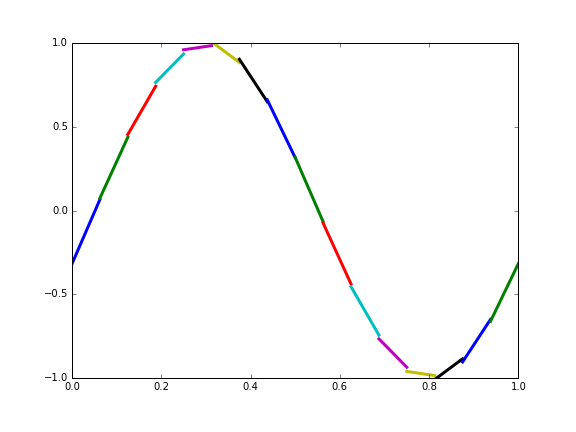

In [9]:
%matplotlib nbagg

fig, ax = plt.subplots(figsize=(8,6))  # create figure

# create initial lines
lines = []
nodes_flat = nodes.reshape(N*k,1)
for i in range(k):
    line, = ax.plot(nodes_flat[2*i:2*i+2], a[2*i:2*i+2], linewidth=3)
    lines.append(line)

def animate(i):
    global a
    
    a_t = np.dot(cM_KF, a) # solve for a_t
    a = a + a_t*dt         # forward Euler update

    # update lines with a values
    for i, line in enumerate(lines):
        line.set_ydata(a[2*i:2*i+2])
    return lines

def init():
    for i, line in enumerate(lines):
        line.set_ydata(a[2*i:2*i+2])
    return lines

# run animation
ani = animation.FuncAnimation(fig, animate, np.arange(1, nt), init_func=init,
                              interval=1, blit=True)